# build kubeflow pipeline with python SDK


* Leverage python SDK 
* Create components and pipelines (YAML)

## parameters - user defined

## required installation

In [1]:
!pip install kfp --upgrade

     |████████████████████████████████| 301 kB 9.8 MB/s eta 0:00:01
  Using cached cloudpickle-2.0.0-py3-none-any.whl (25 kB)
  Created wheel for kfp: filename=kfp-1.8.12-py3-none-any.whl size=419048 sha256=837578a7efdf21cc044031ce45450a87757f4520eced6aa4b26f1d2ad43e2fc3
  Stored in directory: /Users/user1/Library/Caches/pip/wheels/e0/a3/8b/897768051e54a03d4ad9d8211e100fc4cc5439d20743d8ab25
Successfully built kfp
  Attempting uninstall: kfp-pipeline-spec
    Found existing installation: kfp-pipeline-spec 0.1.13
    Uninstalling kfp-pipeline-spec-0.1.13:
      Successfully uninstalled kfp-pipeline-spec-0.1.13


  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.6.0
    Uninstalling cloudpickle-1.6.0:
      Successfully uninstalled cloudpickle-1.6.0
  Attempting uninstall: kfp
    Found existing installation: kfp 1.8.4
    Uninstalling kfp-1.8.4:
      Successfully uninstalled kfp-1.8.4


## import

In [54]:
import kfp
import kfp.components as comp

## 1 Data acquisition and preparation

In [55]:
## load component from yaml
component_download_file = kfp.components.load_component_from_file("./component-sdk-v2.yaml")

def process_data_tarball(file_path: comp.InputPath('Tarball'),
                         output_patient_id_list: comp.OutputPath('CSV'),
                         output_master_df: comp.OutputPath('CSV')):
    """Specific data processing of tarball downloaded.
        - Hard code tarball content names. 
        - Assume there is MANIFEST.txt
        - Output: 
            - output_MANIFEST: MANIFEST.txt as df
            - output_DATA: tables in dict (keys: name as in MANIFEST.txt, values: table)
    
    Args:
        file_path: A string containing path to the tarball.
    """
    from functools import reduce
    import glob
    import json 
    from json import JSONEncoder
    import numpy as np
    import tarfile
    
    import pandas as pd
    
        
    tarfile.open(name=file_path, mode="r|gz").extractall('data_extracted')
    l_tarball_contents = tarfile.open(name=file_path, mode="r|gz").getnames()

    # all dataframes
    d_df_data = {}
    
    for name in l_tarball_contents:
        archive_filename = 'data_extracted/' + name
        if name == 'MANIFEST.txt':
            df_manifest = pd.read_csv(glob.glob(archive_filename)[0], sep = "\t")
        else:
            df = pd.read_csv(glob.glob(archive_filename)[0], sep = "\t")
            df.to_csv(index=False, header=True)
            d_df_data[name] = df    

    filename_patient_table = '57683e22-a8ea-4eca-bfcf-f708cf459546/nationwidechildrens.org_clinical_patient_gbm.txt'
    filename_follow_up_table = 'c9cdbc76-105d-429b-9fce-f000819716f9/nationwidechildrens.org_clinical_follow_up_v1.0_gbm.txt'
            
    # 1 remove un-needed header rows for tables
    df_patient_raw = d_df_data[filename_patient_table]
    df_follow_up_raw = d_df_data[filename_follow_up_table]
    
    ## use the 2nd row as the column name (in raw data, first 3 rows are column labels)
    ### patient table
    df_patient = df_patient_raw.drop([1])
    df_patient = df_patient.tail(len(df_patient) -1 )
    df_patient = df_patient.reset_index().drop(['index'], axis = 1)
    ### follow_up table
    df_follow_up = df_follow_up_raw.drop([1])
    df_follow_up = df_follow_up.tail(len(df_follow_up) -1 )
    df_follow_up = df_follow_up.reset_index().drop(['index'], axis = 1)
    
    
    # 2 data processing
    ## 2a: data processing: clnical data
    
    ### patient table
    missing_value_flags = ['[Not Available]',
                       '[Discrepancy]',
                       '[Unknown]',
                       '[Not Applicable]',
                       '[Not Evaluated]'
                      ]
    #### replace flags with np.nan
    for flag in missing_value_flags:
        df_patient = df_patient.replace(flag, np.nan)
    
    #### drop un-needed columns - identifiers
    df_patient = df_patient.drop(['bcr_patient_uuid', 'form_completion_date', 'patient_id'], axis=1)
    
    #### parse numerical columns w/ dates
    l_numerical_cols = [
        'last_contact_days_to',
        'death_days_to',
        'age_at_initial_pathologic_diagnosis'
    ]
    for col in l_numerical_cols:
        df_patient[col] = [float(x) for x in df_patient[col]]

    df_patient['survival_time_yrs'] = np.abs(df_patient['death_days_to']) / 365
    df_patient['days_since_last_contact'] = np.abs(df_patient['last_contact_days_to']) / 365
    
    #### drop columns parsed / not needed anymore
    l_columns_not_needed = [
        'last_contact_days_to',
        'birth_days_to',
        'death_days_to',

        # uninformative cols (all missing/not evaluated etc):
        'anatomic_neoplasm_subdivision',
        'disease_code',
        'project_code',
        'days_to_initial_pathologic_diagnosis',
        'icd_10',
        'icd_o_3_histology',
        'icd_o_3_site',
        'informed_consent_verified',
        'initial_pathologic_dx_year'

    ]
    df_patient = df_patient.drop(l_columns_not_needed, axis = 1)
    
    
    
    ### follow_up table
    #### replace missing value flags with np.nan
    missing_value_flags = ['[Not Available]',
                           '[Discrepancy]',
                           '[Unknown]',
                           '[Not Applicable]',
                           '[Not Evaluated]'
                          ]
    for flag in missing_value_flags:
        df_follow_up = df_follow_up.replace(flag, np.nan)

    #### drop un-needed columns - identifiers
    df_follow_up = df_follow_up.drop(['bcr_patient_uuid', 'bcr_followup_uuid', 'form_completion_date',
                                     'followup_reason', 'followup_lost_to'], axis=1)

    #### parse numerical columns w/ dates
    l_numerical_cols = [
        'last_contact_days_to',
        'death_days_to'
    ]
    for col in l_numerical_cols:
        df_follow_up[col] = [float(x) for x in df_follow_up[col]]

    #### isolate the LAST followup (sorted by barcode) --> get one row per patient
    df_follow_up = df_follow_up.groupby(['bcr_patient_barcode']).tail(1)

    #### drop columns parsed / not needed anymore
    l_columns_not_needed = [
        'last_contact_days_to',
        'death_days_to',
        'bcr_followup_barcode'
    ]
    df_follow_up = df_follow_up.drop(l_columns_not_needed, axis = 1)
    
    
    # 3 Merge tables by patient identifier (create master table)

    ## merge patient and followup table
    ### find common cols: 
    l_cols_table_1 = set(df_patient.columns)
    l_cols_table_2 = set(df_follow_up.columns)
    intersect_cols = l_cols_table_1.intersection(l_cols_table_2)
    l_cols_to_remove_table_1 = [x for x in intersect_cols if x != 'bcr_patient_barcode']

    ### drop common cols from left table (`patient`) before join
    df_patient = df_patient.drop(l_cols_to_remove_table_1, axis = 1)
    ### join
    df_master = df_patient.merge(df_follow_up, 
                                 left_on = 'bcr_patient_barcode', 
                                 right_on = 'bcr_patient_barcode', 
                                 how = 'inner')
    ### drop patient ID identifier from master table (used as identifier, not treated as a feature)
    df_patient_id_list = df_master[['bcr_patient_barcode']]
    df_master = df_master.drop(['bcr_patient_barcode'], axis = 1)    
        
    # pl output
    df_patient_id_list.to_csv(output_patient_id_list, index=False, header=True)
    df_master.to_csv(output_master_df, index=False, header=True)
    
        
    
create_step_process_data_tarball = kfp.components.create_component_from_func(
    func=process_data_tarball,
    output_component_file='component_process_data_tarball.yaml', # save the component spec for future use.
    base_image='python:3.7',
    packages_to_install=['pandas==1.1.4'])

## 2 Data processing

Further process master table

- select column to be used as class label; 
- for other columns, get dummies

In [757]:
def get_dummies(file_path: comp.InputPath('CSV'),
                file_path_patient_list: comp.InputPath('CSV'),
                class_label_colname: str,
                s_colnames_to_exclude: str,
                output_csv_features: comp.OutputPath('CSV'),
                output_csv_target: comp.OutputPath('CSV'),
                output_csv_target_class_labels: comp.OutputPath('CSV'),
                output_csv_feature_list: comp.OutputPath('CSV'),
                output_csv_patient_list_filtered: comp.OutputPath('CSV')):
    """Distribute categorical features into separate features.
        Input: CSV with categorical (and numeric) features. Assume last 
            feature is target label. 
        Output: CSV with categorical features separated into dummies.
    
    Args:
        file_path: A string containing path to input data.
        output_csv: A string containing path to processed data.
    """
    import glob
    import numpy as np
    import pandas as pd
    from sklearn import preprocessing
    
    df = pd.read_csv(filepath_or_buffer=file_path)
    l_col_names = list(df.columns)
    
    # isolate column for target class label; if null, use last column
    target_class_label = class_label_colname if str(class_label_colname) != '' else l_col_names[-1]
    ## remove all rows where class label col is NaN
    df = df.dropna(subset=[target_class_label])
    ## remove patients from master list whose data got removed because class label col was NaN
    df_patient_list = pd.read_csv(file_path_patient_list)
    df_patient_list_filtered = df_patient_list.loc[df.index]

    
    ## extract target class column
    df_target_raw = df[target_class_label] # from input parameter
    lb = preprocessing.LabelBinarizer()
    lb.fit(df_target_raw.astype(str)) # fit to data for target class to find all classes
    target_class_label_names = lb.classes_ # store array of all the classes
#    df_target = pd.DataFrame(np.array(lb.fit_transform(df_target_raw)))

    df_target_class_labels = pd.DataFrame({'class': target_class_label_names})
    d_target_class_label_idx = dict(zip(list(df_target_class_labels['class']), list(df_target_class_labels.index)))
    
    l_target_column = [d_target_class_label_idx[x] for x in df[target_class_label]]
    df_target = pd.DataFrame([])
    df_target[target_class_label] = l_target_column# 1-column of multiple classes
    

    
    # create dummies for every col except class label col
    df_features = df[[x for x in l_col_names if x != class_label_colname]] # features are all colnames except target class
    
    # exclude any other colnames (other than target class column), if specified; 
    ## performed on feature matrix after dummies are removed
    if str(s_colnames_to_exclude) != '':
        l_colnames_to_exclude = s_colnames_to_exclude.split(',')
        l_colnames_in_this_df_to_exclude = [x for x in l_colnames_to_exclude if x in df.columns]
        df_features = df_features.drop(l_colnames_to_exclude, axis = 1)
    
    # get dummies
    df_features_dummies = pd.get_dummies(df_features)
    
    # feature list
    l_features = df_features_dummies.columns
    df_feature_list = pd.DataFrame({'feature': l_features})
        
    # write outputs
    df_features_dummies.to_csv(output_csv_features, index = False, header = True)
    df_target.to_csv(output_csv_target, index = False, header = True)
    df_target_class_labels.to_csv(output_csv_target_class_labels, index = True, header = False)
    df_feature_list.to_csv(output_csv_feature_list, index = True, header = False)
    ### save new filtered patient list
    df_patient_list_filtered.to_csv(output_csv_patient_list_filtered, header=True, index=False)

create_step_dp_get_dummies = kfp.components.create_component_from_func(
    func=get_dummies,
    output_component_file='component_dp_get_dummies.yaml', # save the component spec for future use.
    base_image='python:3.7',
    packages_to_install=['pandas==1.1.4',
                        'scikit-learn==1.0.2'])

## download images - from DIGITAL SLIDE ARCHIVE

Acquire images given `bcr_patient_barcode` - fits in pipeline as shown in image below

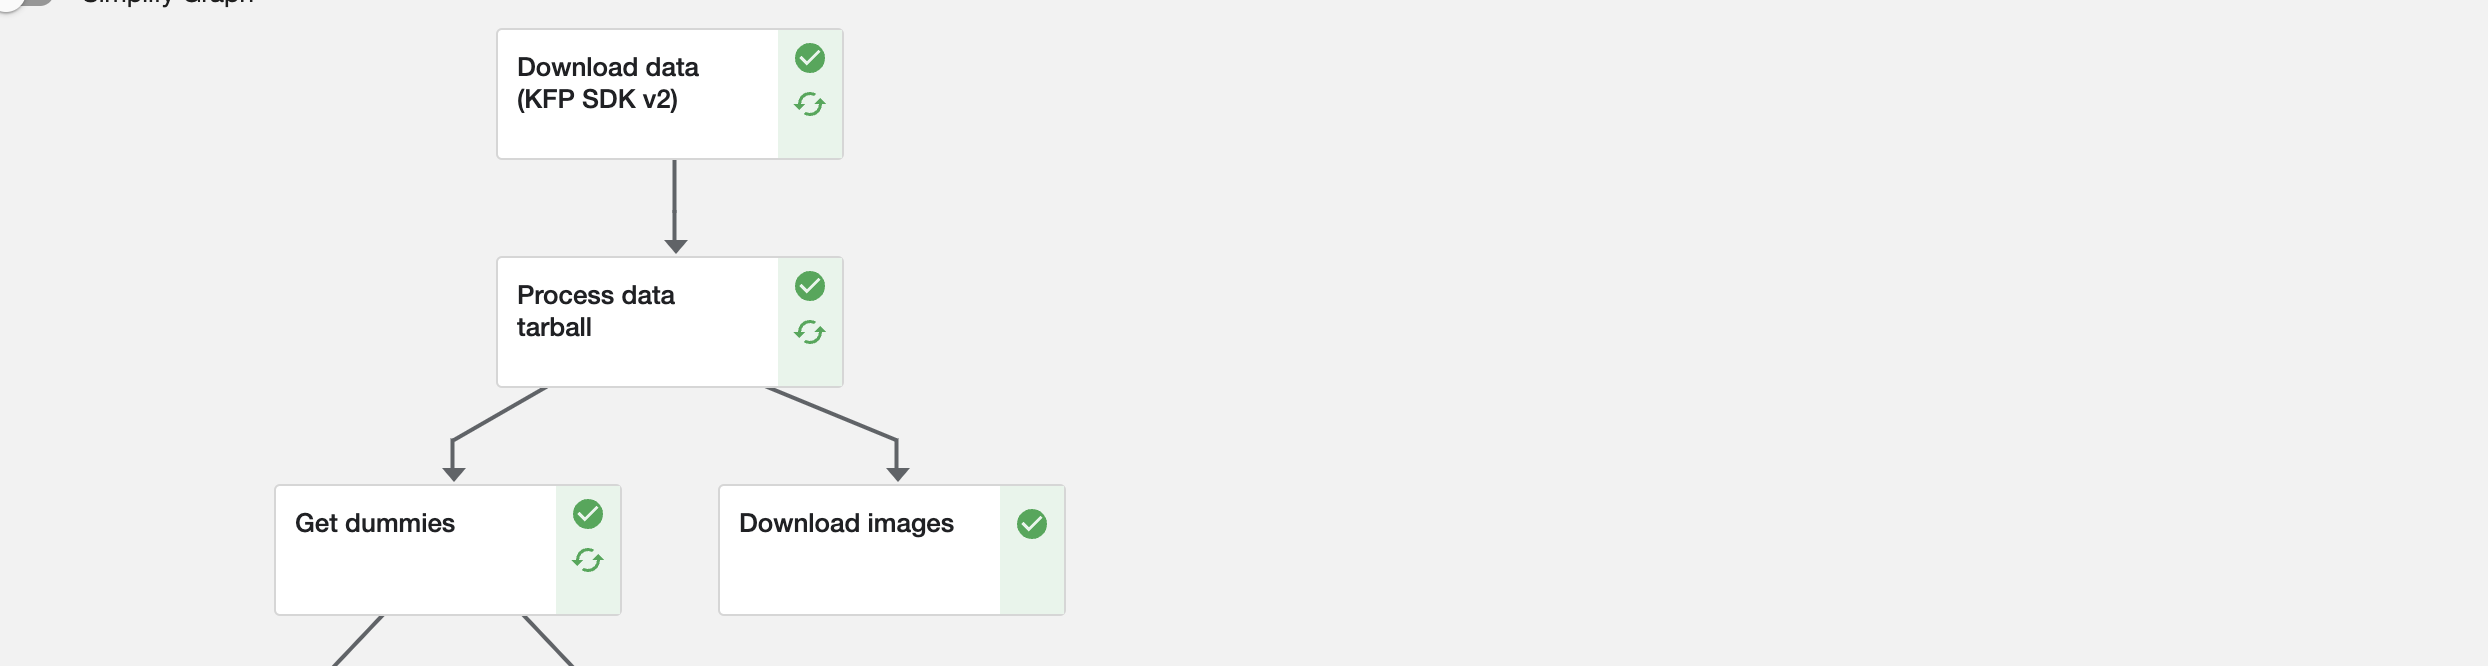

In [586]:
def download_images(file_path_patient_list: comp.InputPath('CSV'),
                    outfile_images_json: comp.OutputPath('JSON')):
    """Acquisition of images associated with patients listed
        in master `patient` table. 
    
    Args:
        file_path: A string containing path to the tarball.
    """
    import json 
    from json import JSONEncoder
    import cv2
    import girder_client
    import numpy as np
    import pandas as pd

    class NumpyArrayEncoder(JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            return JSONEncoder.default(self, obj)
        
    gc = girder_client.GirderClient(apiUrl="https://api.digitalslidearchive.org/api/v1")

    # list of patients; header col name = "bcr_patient_barcode"
    df_patient_list = pd.read_csv(file_path_patient_list)

    ## FYI: image name format:
    ##    <patient_id>-01Z-00-DX1.<string>.svs
    ##    TCGA-02-0038-01Z-00-DX1.5E369837-371E-4845-AD78-84BB48E1A082.svs

    
    # retrieve images by ptID in list
    l_imagelist_ptID = []
    l_imagelist_imgID = []
    l_imagelist_imgContent = []
    for ptID in df_patient_list['bcr_patient_barcode']:

        # get case metadata for this patient
        caseMetadata = gc.get('tcga/case/label/%s' % ptID)
        # get caseId for this patient
        caseId =  caseMetadata['tcga']['caseId']


        # Get images for this case ID..
        imageData = gc.get("/tcga/case/%s/images" % caseId)

        for i in imageData['data']:
            if i['name'].split('.')[0].split('-')[-1] == 'DX1':
                print(i['name'],i['_id'])
                l_imagelist_ptID.append(ptID)
                l_imagelist_imgID.append(i['_id'])

    for i in range(len(l_imagelist_imgID)):
        # retrieve image content with image ID
        imgID = l_imagelist_imgID[i]
        imageThumb = gc.get("item/%s/tiles/thumbnail" % imgID,jsonResp=False)
        img_array = np.frombuffer(imageThumb.content, dtype=np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        l_imagelist_imgContent.append(img)


    # image shape
    img_shape = l_imagelist_imgContent[0].shape # assume all images are same shape
    df_img_shape = pd.DataFrame([])
    df_img_shape['img_shape'] = img_shape
                    
    # JSON of all images
    d_images = dict()
    for i in range(len(l_imagelist_ptID)):
        ptID = l_imagelist_ptID[i]
        if ptID not in d_images:
            d_images[ptID] = []
        d_images[ptID].append(l_imagelist_imgContent[i])
    json_string_output = json.dumps(d_images, cls=NumpyArrayEncoder)

    # write outputs
    ## write json file
    with open(outfile_images_json, 'w') as outfile:
        outfile.write(json_string_output)
    
    
create_step_download_images = kfp.components.create_component_from_func(
    func=download_images,
    output_component_file='component_download_images.yaml', # save the component spec for future use.
    base_image='python:3.7',
    packages_to_install=['girder_client==3.1.8',
                         'numpy==1.21.2',
                         'opencv-python-headless==4.5.5.62',
                         'pandas==1.1.4'])

## feature construction - from images

Construct features from images

### feature construction domain 1

In [734]:
def construct_features_image_fx(file_path_images: comp.InputPath('JSON'),
                                file_path_full_patient_id_list: comp.InputPath('CSV'),
                                file_path_full_patient_class_labels: comp.InputPath('CSV'),
                                outfile_features_df: comp.OutputPath('CSV'),
                                outfile_patient_id_list: comp.OutputPath('CSV'),
                                outfile_class_labels_pts_with_images: comp.OutputPath('CSV')):
    """Feature construction from images. 
    
    Args:
        file_path: A string containing path to images (3-channel) in JSON obj.
    """


    import json
    from collections import OrderedDict
    import numpy as np
    import pandas as pd
    from skimage.filters import prewitt_h,prewitt_v
    

    # openCV features
    input_filestream_json = "./output/json_10_images.json"

    with open(file_path_images, "r") as read_file:
        d_images_from_pl = json.load(read_file)


    d_features = OrderedDict()
    d_features["mean_weight_raw_img"] = []
    d_features["mean_edge_weight_horizontal"] = []
    d_features["mean_edge_weight_vertical"] = []

    l_ptID = np.sort(list(d_images_from_pl.keys()))
    for ptID in l_ptID:
        img = np.array(
                d_images_from_pl[
                    ptID]
                        [0] # use the first image for the pt
                )
        # feature extraction

        ## calculating horizontal edges using prewitt kernel
        edges_prewitt_horizontal = prewitt_h(img[:,:,0])
        ## calculating vertical edges using prewitt kernel
        edges_prewitt_vertical = prewitt_v(img[:,:,0])

        ## Feature: mean values 
        mean_weight_raw_img = np.mean(img)
        d_features["mean_weight_raw_img"].append(mean_weight_raw_img)

        ## Feature: mean values 
        mean_edge_weight_horizontal = np.mean(edges_prewitt_horizontal)
        d_features["mean_edge_weight_horizontal"].append(mean_edge_weight_horizontal)

        ## Feature: mean values 
        mean_edge_weight_vertical = np.mean(edges_prewitt_vertical)
        d_features["mean_edge_weight_vertical"].append(mean_edge_weight_vertical)

    df_features_combined = pd.DataFrame([])
    df_features_combined['bcr_patient_barcode'] = l_ptID
    for feature_name in d_features.keys():
        df_features_combined[feature_name] = d_features[feature_name]

    # output patient ID list
    df_patient_id_list = df_features_combined[['bcr_patient_barcode']]
    df_patient_id_list.to_csv(outfile_patient_id_list, header = True, index = False)
    
    # output features
    del df_features_combined['bcr_patient_barcode']
    df_features_combined.to_csv(outfile_features_df, header = True, index = False)

    # output target class labels for this cohort of patients (not all patients in full
    #  cohort will have images)
    df_full_patient_id_list = pd.read_csv(file_path_full_patient_id_list)
    df_full_patient_class_labels = pd.read_csv(file_path_full_patient_class_labels)
    ## isolate patients that have images
    df_slice_full_patient_id_list_have_images = df_full_patient_id_list[df_full_patient_id_list['bcr_patient_barcode'].isin(df_patient_id_list['bcr_patient_barcode'])]
    idx_in_full_patient_id_list_have_images = df_slice_full_patient_id_list_have_images.index
    df_class_labels_pts_with_images = df_full_patient_class_labels.loc[idx_in_full_patient_id_list_have_images]
    
    df_class_labels_pts_with_images.to_csv(outfile_class_labels_pts_with_images, header=True, index=False)
    df_slice_full_patient_id_list_have_images.to_csv(outfile_patient_id_list, header=True, index=False)
    
    
create_step_image_feature_construction_image_fx = kfp.components.create_component_from_func(
    func=construct_features_image_fx,
    output_component_file='component_image_feature_construction.yaml', # save the component spec for future use.
    base_image='python:3.7',
    packages_to_install=['scikit-image==0.19.1',
                         'numpy==1.21.2',
                         'opencv-python-headless==4.5.5.62',
                         'pandas==1.1.4'])

## component: combine feature domains 

In [760]:
def combine_feature_domains(file_path_image_fx: comp.InputPath('CSV'),
                            file_path_clinical_fx: comp.InputPath('CSV'),
                            file_path_image_patient_id: comp.InputPath('CSV'),
                            file_path_clinical_patient_id: comp.InputPath('CSV'),
                            outfile_master_features_df: comp.OutputPath('CSV'),
                            outfile_master_patient_id_list: comp.OutputPath('CSV')):
    
    """Combination of features (concatenation) for early fusion model. 
    
    Args:
        file_path_image_fx: 
        file_path_clinical_fx:
        file_path_image_patient_id:
        file_path_clinical_patient_id: 
    """

    import pandas as pd

    df_image_fx = pd.read_csv(file_path_image_fx)
    df_clinical_fx = pd.read_csv(file_path_clinical_fx)
    df_image_patient_id = pd.read_csv(file_path_image_patient_id)
    df_clinical_patient_id = pd.read_csv(file_path_clinical_patient_id)
    
    # slap on patient id column as first column
    df_image_table_with_patient_id = pd.concat([df_image_patient_id, df_image_fx],
                                               axis=1)
    df_clinical_table_with_patient_id = pd.concat([df_clinical_patient_id, df_clinical_fx],
                                                  axis=1)

    # merge data domains
    df_master_features = df_image_table_with_patient_id.merge(df_clinical_table_with_patient_id,
                                                              how='outer',
                                                              on='bcr_patient_barcode')

    # write outputs
    df_master_patient_id_list = df_master_features[['bcr_patient_barcode']]
    del df_master_features['bcr_patient_barcode']
    
    df_master_features.to_csv(outfile_master_features_df, header=True, index=False)
    df_master_patient_id_list.to_csv(outfile_master_patient_id_list, header=True, index=False)
    
    l_feature_names_images = list(set(df_image_fx.columns).intersection(df_master_features.columns)) 
    
create_step_combine_feature_domains = kfp.components.create_component_from_func(
    func=combine_feature_domains,
    output_component_file='component_combine_feature_domains.yaml', # save the component spec for future use.
    base_image='python:3.7',
    packages_to_install=['pandas==1.1.4'])

### Component: Imputation

In [296]:
def impute_unknown(file_path: comp.InputPath('CSV'),
                   output_csv: comp.OutputPath('CSV')):
    """Impute unknown values (nan).
        Input: CSV.
        Output: CSV.
    
    Args:
        file_path: A string containing path to input data.
        output_csv: A string containing path to processed data.
    """
    import numpy as np
    import pandas as pd
    from sklearn.impute import SimpleImputer
    
    # Read in CSV
    df = pd.read_csv(filepath_or_buffer=file_path)
    
    # Impute: most common
    imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp_most_frequent.fit(df)
    nparr_imputed = imp_most_frequent.transform(df)
    df_imputed = pd.DataFrame(nparr_imputed)
    df_imputed.columns = df.columns
    
    # Output to CSV
    df_imputed.to_csv(output_csv, index = False, header = True)

create_step_dp_impute_unknown = kfp.components.create_component_from_func(
    func=impute_unknown,
    output_component_file='component_dp_impute_unknown.yaml', # save the component spec for future use.
    base_image='python:3.7',
    packages_to_install=['pandas==1.1.4',
                         'scikit-learn==1.0.2'])

### Component: Scaler

In [268]:
def scale_df(file_path: comp.InputPath('CSV'),
             output_csv: comp.OutputPath('CSV')):
    """Impute unknown values (nan).
        Input: CSV.
        Output: CSV.
    
    Args:
        file_path: A string containing path to input data.
        output_csv: A string containing path to processed data.
    """
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    
    # Read in CSV
    df = pd.read_csv(filepath_or_buffer=file_path)
    
    # scaler
    scaler = StandardScaler()
    scaler.fit(df)
    nparr_scaled_data = scaler.transform(df)
    
    df_scaled = pd.DataFrame(nparr_scaled_data)
    df_scaled.columns = df.columns
    
    # Output to CSV
    df_scaled.to_csv(output_csv, index = False, header = True)

create_step_dp_scale_df = kfp.components.create_component_from_func(
    func=scale_df,
    output_component_file='component_dp_scale_df.yaml', # save the component spec for future use.
    base_image='python:3.7',
    packages_to_install=['pandas==1.1.4',
                        'scikit-learn==1.0.2'])

### Component: create model inputs: X,y

In [240]:
def create_model_inputs(file_path_features: comp.InputPath('CSV'),
                        file_path_class_labels: comp.InputPath('CSV'),
                        test_set_size: str,
                        output_X_train: comp.OutputPath('CSV'),
                        output_X_test: comp.OutputPath('CSV'),
                        output_y_train: comp.OutputPath('CSV'),
                        output_y_test: comp.OutputPath('CSV')):
    """Create train and test sets
    
    Args:
        file_path_features: A string containing path / pipeline component output
        file_path_class_labels: A string containing path to data / pipeline component output
        test_set_size: [optional, default=0.25] proportion to use for the test set
    """
    import numpy as np
    
    import pandas as pd
    from sklearn import datasets
    from sklearn.model_selection import train_test_split

    X = pd.read_csv(filepath_or_buffer=file_path_features)
    y = pd.read_csv(filepath_or_buffer=file_path_class_labels)
    
    try:
        test_set_size_for_model_training = float(test_set_size)
    except:
        test_set_size_for_model_training = 0.25
    if test_set_size_for_model_training <= 0 or test_set_size_for_model_training >= 1:
        test_set_size_for_model_training = 0.25
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size_for_model_training)
    
    X_train.to_csv(output_X_train, header=True, index=False)
    X_test.to_csv(output_X_test, header=True, index=False)
    y_train.to_csv(output_y_train, header=True, index=False)
    y_test.to_csv(output_y_test, header=True, index=False)

    
create_step_dp_create_train_test = kfp.components.create_component_from_func(
    func=create_model_inputs,
    output_component_file='component_dp_create_train_test.yaml', # save the component spec for future use.
    base_image='python:3.7',
    packages_to_install=['pandas==1.1.4',
                         'scikit-learn==1.0.2'])

## 3 model train

In [357]:
def train_model(file_path_x_train: comp.InputPath('CSV'), 
                file_path_y_train: comp.InputPath('CSV'),
                output_model: comp.OutputPath('Model')):
    import joblib
    import mlflow.sklearn
    import pandas as pd
    from sklearn.linear_model import LogisticRegression
    from sklearn import preprocessing

    
    X_train = pd.read_csv(file_path_x_train)
    y_train_raw = pd.read_csv(file_path_y_train)
    
    
#     lb = preprocessing.LabelBinarizer()
#     lb.fit_transform(y_train_raw.astype(str))
#     y_class_labels = lb.classes_ #
#     print('y_class_labels: ', y_class_labels) #
#     y_train = lb.fit_transform(y_train_raw.astype(str))    
    
    y_train=y_train_raw
    
    model = LogisticRegression(verbose=1,
                               penalty='l2',
                               tol=1e-4,
                               C=1.0,
                               class_weight='balanced',
                               solver='lbfgs',
                               multi_class='ovr')
    model.fit(X_train, y_train)

    
    mlflow.sklearn.save_model(model, output_model,
                          serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)

    # log model
    mlflow.sklearn.log_model(model, "sklearn_models")

create_step_train_model = kfp.components.create_component_from_func(
    func=train_model,
    output_component_file='component_train_model.yaml', 
    base_image='python:3.7',
    packages_to_install=['joblib==1.1.0',
                         'mlflow==1.24.0',
                         'pandas==1.1.4',
                         'scikit-learn==1.0.2'])

## 4 Test

In [483]:
def test_model(file_path_x_test: comp.InputPath('CSV'),
               file_path_y_test: comp.InputPath('CSV'),
               file_path_model: comp.InputPath('Model'),
               output_json: comp.OutputPath('JSON'),
               output_csv:  comp.OutputPath('CSV')):
    import joblib
    import json
    import mlflow.sklearn
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import roc_auc_score
    from sklearn.preprocessing import LabelBinarizer

    class NumpyArrayEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            return json.JSONEncoder.default(self, obj)
        
    trained_model = mlflow.sklearn.load_model(file_path_model)
    
    X_test = pd.read_csv(file_path_x_test)
    y_test = np.array(pd.read_csv(file_path_y_test))
    
    # Get predictions 
    y_pred = trained_model.predict(X_test)
    
    
    #############################################################
    
    
    # Get accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Confusion matrix - use labels
    cm = confusion_matrix(y_test, y_pred)
    
    # AUC score
    sum_y_test_axis_0 = np.sum(y_test, axis=0)
    col_idx_y_test_nnz = np.where(sum_y_test_axis_0 > 0)[0]
    
    # compute AUC 

    ## check if multi-class
    num_classes = np.max([len(np.unique(y_pred)), len(np.unique(y_test))])
    if num_classes > 2: # one-hot encode
        lb = LabelBinarizer()
        lb.fit(np.concatenate((np.array(y_test).ravel(), np.array(y_pred).ravel())))
        y_test_onehot = lb.fit_transform(y_test)
        y_pred_onehot = lb.fit_transform(y_pred)
    else:
        y_test_onehot = y_test
        y_pred_onehot = y_pred
        
    auc_test = roc_auc_score(y_test_onehot,
                             y_pred_onehot,
                             multi_class=trained_model.multi_class) # specify multi-class method

    # output: JSON
    d_output = {}
    ## add in model results
    d_output['model_results'] = {}
    d_output['model_results']['model'] = trained_model.get_params()
    d_output['model_results']['y_test'] = np.array(y_test).ravel()
    d_output['model_results']['y_pred'] = y_pred
    d_output['model_results']['accuracy'] = accuracy
    d_output['model_results']['auc_test'] = auc_test
    d_output['model_results']['cm'] = cm

    json_string_output = json.dumps(d_output, cls=NumpyArrayEncoder)
    
    ## write json output: results
    with open(output_json, 'w') as outfile:
        outfile.write(json_string_output)
        
    ## write csv output: results
    df_output_csv = pd.DataFrame({'metric': d_output['model_results'].keys(),
                                  'value':  d_output['model_results'].values()})
    df_output_csv.to_csv(output_csv, index = False, header = True)
    
create_step_test_model = kfp.components.create_component_from_func(
    func=test_model,
    output_component_file='component_test_model.yaml', 
    base_image='python:3.7',
    packages_to_install=['joblib==1.1.0',
                         'mlflow==1.24.0',
                         'pandas==1.1.4',
                         'scikit-learn==1.0.2'])

## 5 Performance Analysis

### Final Pipeline GBM v3: early fusion

In [762]:
def pl_GBM_v3_early_fusion_clinical_images(user_input_class_label_column_name,
                                           s_colnames_to_exclude,
                                           test_set_size):
    """Pipeline: Download data, data processing
        1. download data and make master table
        2. data processing
        3. train model
    
    Args:
        user_input_class_label_column_name: name of column to use as class label (i.e., vital_status)
        s_colnames_to_exclude: other columns to exclude, other than the ones automatically 
                               filtered out in make_dfs(); separate colnames by ','
    """
    
    # PL1: FULL PIPELINE - Clinical data only
    url = 'https://wiki.cancerimagingarchive.net/download/attachments/1966258/gdc_download_clinical_gbm.tar.gz'
    web_downloader_task = component_download_file(url)
    make_dfs = create_step_process_data_tarball(file=web_downloader_task.outputs['data'])
    dp_get_dummies_task = create_step_dp_get_dummies(file=make_dfs.outputs['output_master_df'],
                                                     file_path_patient_list=make_dfs.outputs['output_patient_id_list'],
                                                     class_label_colname=user_input_class_label_column_name, 
                                                     s_colnames_to_exclude=s_colnames_to_exclude)
    dp_impute_task = create_step_dp_impute_unknown(file=dp_get_dummies_task.outputs['output_csv_features'])
    dp_scale_task = create_step_dp_scale_df(file=dp_impute_task.outputs['output_csv'])
    dp_create_train_test = create_step_dp_create_train_test(file_path_features=dp_scale_task.outputs['output_csv'], 
                                                            file_path_class_labels=dp_get_dummies_task.outputs['output_csv_target'],
                                                            test_set_size=test_set_size)
    train_model_task = create_step_train_model(file_path_x_train=dp_create_train_test.outputs['output_X_train'],
                                               file_path_y_train=dp_create_train_test.outputs['output_y_train'])
    test_model_task = create_step_test_model(file_path_x_test=dp_create_train_test.outputs['output_X_test'],
                                             file_path_y_test=dp_create_train_test.outputs['output_y_test'],
                                             file_path_model=train_model_task.outputs['output_model'])
    
    
    # DATA ACQUISITION: image features
    get_images_task = create_step_download_images(file_path_patient_list=make_dfs.outputs['output_patient_id_list'])
    create_image_features_task = create_step_image_feature_construction_image_fx(file_path_images=get_images_task.outputs['outfile_images_json'],
                                                                                 file_path_full_patient_id_list=dp_get_dummies_task.outputs['output_csv_patient_list_filtered'],
                                                                                 file_path_full_patient_class_labels=dp_get_dummies_task.outputs['output_csv_target'])
    
    # DATA PREPARATION: fusion image and clinical data feature domains
    task_combine_feature_domains = create_step_combine_feature_domains(file_path_image_fx=create_image_features_task.outputs['outfile_features_df'],
                                                                       file_path_clinical_fx=dp_get_dummies_task.outputs['output_csv_features'],
                                                                       file_path_image_patient_id=create_image_features_task.outputs['outfile_patient_id_list'],
                                                                       file_path_clinical_patient_id=dp_get_dummies_task.outputs['output_csv_patient_list_filtered'])
    # PL2: MODELING PORTION OF PIPELINE: Image data only
    task_images_only_impute = create_step_dp_impute_unknown(file=create_image_features_task.outputs['outfile_features_df'])
    task_images_only_scale = create_step_dp_scale_df(file=task_images_only_impute.outputs['output_csv'])    
    task_images_only_create_train_test = create_step_dp_create_train_test(file_path_features=task_images_only_scale.outputs['output_csv'], 
                                                                          file_path_class_labels=create_image_features_task.outputs['outfile_class_labels_pts_with_images'], #note: the image data 
                                                                             # acquisition component currently assumes only patients that
                                                                             # have clinical data are searched for images; ie no patients 
                                                                             # that would have images but no clinical data
                                                                          test_set_size=test_set_size)
    task_images_only_train_model = create_step_train_model(file_path_x_train=task_images_only_create_train_test.outputs['output_X_train'],
                                                           file_path_y_train=task_images_only_create_train_test.outputs['output_y_train'])
    task_images_only_test_model = create_step_test_model(file_path_x_test=task_images_only_create_train_test.outputs['output_X_test'],
                                                          file_path_y_test=task_images_only_create_train_test.outputs['output_y_test'],
                                                          file_path_model=task_images_only_train_model.outputs['output_model'])
    

    
    # PL3: MODELING PORTION OF PIPELINE: FUSION (Image + Clinical data)
    task_early_fusion_impute = create_step_dp_impute_unknown(file=task_combine_feature_domains.outputs['outfile_master_features_df'])
    task_early_fusion_scale = create_step_dp_scale_df(file=task_early_fusion_impute.outputs['output_csv'])    
    task_early_fusion_create_train_test = create_step_dp_create_train_test(file_path_features=task_early_fusion_scale.outputs['output_csv'], 
                                                                           file_path_class_labels=dp_get_dummies_task.outputs['output_csv_target'], #note: the image data 
                                                                             # acquisition component currently assumes only patients that
                                                                             # have clinical data are searched for images; ie no patients 
                                                                             # that would have images but no clinical data
                                                                           test_set_size=test_set_size)
    task_early_fusion_train_model = create_step_train_model(file_path_x_train=task_early_fusion_create_train_test.outputs['output_X_train'],
                                                            file_path_y_train=task_early_fusion_create_train_test.outputs['output_y_train'])
    task_early_fusion_test_model = create_step_test_model(file_path_x_test=task_early_fusion_create_train_test.outputs['output_X_test'],
                                                          file_path_y_test=task_early_fusion_create_train_test.outputs['output_y_test'],
                                                          file_path_model=task_early_fusion_train_model.outputs['output_model'])
    
    
    
kfp.compiler.Compiler().compile(
    pipeline_func=pl_GBM_v3_early_fusion_clinical_images,
    package_path='pl_GBM_v3_early_fusion_clinical_images.yaml')

# XXX DEBUG

In [592]:
import cv2
import girder_client
import json
from json import JSONEncoder
import numpy as np
import pandas as pd

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
    
gc = girder_client.GirderClient(apiUrl="https://api.digitalslidearchive.org/api/v1")

# list of patients; header col name = "bcr_patient_barcode"
df_patient_list = pd.read_csv('./output/data')

## FYI: image name format:
##    <patient_id>-01Z-00-DX1.<string>.svs
##    TCGA-02-0038-01Z-00-DX1.5E369837-371E-4845-AD78-84BB48E1A082.svs


# retrieve images by ptID in list
l_imagelist_ptID = []
l_imagelist_imgID = []
l_imagelist_imgContent = []
for ptID in df_patient_list['bcr_patient_barcode'][:10]:

    # get case metadata for this patient
    caseMetadata = gc.get('tcga/case/label/%s' % ptID)
    # get caseId for this patient
    caseId =  caseMetadata['tcga']['caseId']


    # Get images for this case ID..
    imageData = gc.get("/tcga/case/%s/images" % caseId)

    for i in imageData['data']:
        if i['name'].split('.')[0].split('-')[-1] == 'DX1':
            print(i['name'],i['_id'])
            l_imagelist_ptID.append(ptID)
            l_imagelist_imgID.append(i['_id'])

for i in range(len(l_imagelist_imgID)):
    # retrieve image content with image ID
    imgID = l_imagelist_imgID[i]
    imageThumb = gc.get("item/%s/tiles/thumbnail" % imgID,jsonResp=False)
    img_array = np.frombuffer(imageThumb.content, dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    l_imagelist_imgContent.append(img)


# image shape
img_shape = l_imagelist_imgContent[0].shape # assume all images are same shape
df_img_shape = pd.DataFrame([])
df_img_shape['img_shape'] = img_shape



# JSON of all images
d_images = dict()
##for i in range(len(l_imagelist_ptID)):
for i in range(len(l_imagelist_ptID[:10])):
    ptID = l_imagelist_ptID[i]
    if ptID not in d_images:
        d_images[ptID] = []
    d_images[ptID].append(l_imagelist_imgContent[i])

# write outputs
json_string_output = json.dumps(d_images, cls=NumpyArrayEncoder)
## write json file
with open("./output/json_10_images.json", 'w') as outfile:
    outfile.write(json_string_output)



# # dataframe of all images: one COLUMN per patient (each col is 1d array for image)
# l_imagelist_imgContent_1d = [x.ravel() for x in l_imagelist_imgContent]
# df_patient_img = pd.DataFrame([])
# for i in range(len(l_imagelist_ptID)):
#     ptID = l_imagelist_ptID[i]
#     df_patient_img[ptID] = l_imagelist_imgContent_1d[i]




TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b156-2908e75f2e47.svs 5b9f00eae62914002e94cef9
TCGA-02-0003-01Z-00-DX1.6171b175-0972-4e84-9997-2f1ce75f4407.svs 5b9f00ece62914002e94cf12
TCGA-02-0004-01Z-00-DX1.d8189fdc-c669-48d5-bc9e-8ddf104caff6.svs 5b9f00efe62914002e94cf2c
TCGA-02-0006-01Z-00-DX1.a37df719-8b93-4245-ae49-67eb1114253a.svs 5b9f00f0e62914002e94cf3a
TCGA-02-0007-01Z-00-DX1.a888f75e-6c41-44c3-8eb6-721f992873b8.svs 5b9f00f2e62914002e94cf50
TCGA-02-0009-01Z-00-DX1.5eceecd9-a9e2-421c-ab48-dbf24e95c64d.svs 5b9f00f3e62914002e94cf60
TCGA-02-0010-01Z-00-DX1.b53f8c4e-6e10-4684-b7fc-fd9e0b9d6c01.svs 5b9f00ebe62914002e94cf01
TCGA-02-0011-01Z-00-DX1.7CF44982-AE5A-47A5-8D07-E526522DC094.svs 5b9f00eee62914002e94cf23
TCGA-02-0014-01Z-00-DX1.b7fd5196-fc51-4dc7-aa6d-e74e1e9ee71d.svs 5b9f00f0e62914002e94cf33
TCGA-02-0015-01Z-00-DX1.73c07790-a054-4725-b123-4f09a2de961a.svs 5b9f00f0e62914002e94cf38


## local implementation - feature extraction

In [681]:
import json
from collections import OrderedDict
from skimage.filters import prewitt_h,prewitt_v


# openCV features
input_filestream_json = "./output/json_10_images.json"

with open(input_filestream_json, "r") as read_file:
    d_images_from_pl = json.load(read_file)
    
    
d_features = OrderedDict()
d_features["mean_weight_raw_img"] = []
d_features["mean_edge_weight_horizontal"] = []
d_features["mean_edge_weight_vertical"] = []

l_ptID = np.sort(list(d_images_from_pl.keys()))
for ptID in l_ptID:
    img = np.array(
            d_images_from_pl[
                ptID]
                    [0] # use the first image for the pt
            )
    # feature extraction
    
    ## calculating horizontal edges using prewitt kernel
    edges_prewitt_horizontal = prewitt_h(img[:,:,0])
    ## calculating vertical edges using prewitt kernel
    edges_prewitt_vertical = prewitt_v(img[:,:,0])
    
    ## Feature: mean values 
    mean_weight_raw_img = np.mean(img)
    d_features["mean_weight_raw_img"].append(mean_weight_raw_img)
    
    ## Feature: mean values 
    mean_edge_weight_horizontal = np.mean(edges_prewitt_horizontal)
    d_features["mean_edge_weight_horizontal"].append(mean_edge_weight_horizontal)
    
    ## Feature: mean values 
    mean_edge_weight_vertical = np.mean(edges_prewitt_vertical)
    d_features["mean_edge_weight_vertical"].append(mean_edge_weight_vertical)

df_features_combined = pd.DataFrame([])
df_features_combined['bcr_patient_barcode'] = l_ptID
for feature_name in d_features.keys():
    df_features_combined[feature_name] = d_features[feature_name]

    

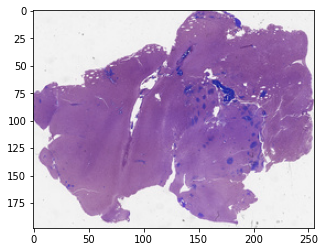

In [638]:
plt.imshow(img)

### example of feature 

mean_weight_raw_img: %s 210.20227025817996
mean_edge_weight_horizontal: %s 4.8327646683832e-22
mean_edge_weight_vertical: %s -4.074072580658727e-21


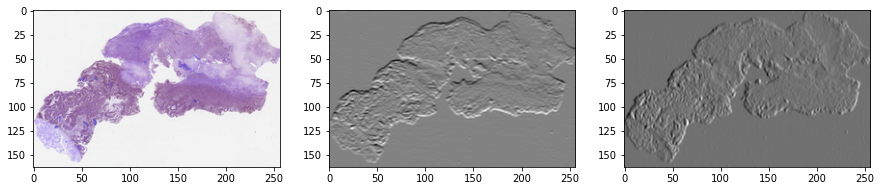

In [678]:
#calculating horizontal edges using prewitt kernel
edges_prewitt_horizontal = prewitt_h(img[:,:,0])
#calculating vertical edges using prewitt kernel
edges_prewitt_vertical = prewitt_v(img[:,:,0])

plt.figure(figsize=[15,45])
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(edges_prewitt_horizontal, cmap='gray')
plt.subplot(133)
plt.imshow(edges_prewitt_vertical, cmap='gray')

mean_weight_raw_img = np.mean(img)
mean_edge_weight_horizontal = np.mean(edges_prewitt_horizontal)
mean_edge_weight_vertical = np.mean(edges_prewitt_vertical)

print("mean_weight_raw_img: %s", mean_weight_raw_img)
print("mean_edge_weight_horizontal: %s", mean_edge_weight_horizontal)
print("mean_edge_weight_vertical: %s", mean_edge_weight_vertical)

